In [5]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


# TESTING FISHER_CMB.PY 

##  First lets try to remake the Fig 3 from Benson 2014

### First import the necessary modules

In [6]:
from Fisher_CMB import *
from Models.SPT3G.spt3G_model import spt3G_model
from Models.Planck.Planck_model import planck_model
from pickle import load as pload
from Covariances.create_basic_cov import *

#### Best guess for the parameters used to make the figure WMAP + SPTSZ

In [9]:
params={'H0':72.5,#'cosmomc_theta': 1.0429e-2,
                           'ombh2':0.0223,
                           'omch2':0.1093,
                           'tau':0.083,
                           'As':2.142e-09,#*exp(2*0.068),
                           'ns':0.9623,
                           'lmax':6000,
                           'lens_potential_accuracy':2.0}

#### Create the covariances for SPT3G  and planck that will be saved to files

In [10]:

create_basic_cov(.06,.0003,(2.5,'ukarc'),
                     filename="Covariances/spt3G_cov_ell_200_5000.p",
                     time= 3.7e7,
                     specrange = (200,5000),
                     bin_size = 24,
                     spectra=('TT','EE','TE'),
                     params=params
                     )

In [7]:

create_basic_cov(.65,.00145,(62,'uks'),
                     filename="Covariances/planck_cov_ell_2_5000.p",
                     time= 3.7e7,
                     specrange = (2,5000),
                     bin_size = 24,
                     spectra=('TT','EE','TE'),
                     params=params
                     )

#### load the pickled covariances

In [6]:
scov=pload(open( "Covariances/spt3G_cov_ell_200_5000.p", "rb" ))
pcov_ell_2_5000=pload(open( "Covariances/planck_cov_ell_2_5000.p", "rb" ))


####  Creat models for SPT3G and Planck and cut out the portion that corresponds to D_b_EE

In [7]:
ms=spt3G_model(specrange = [('TT',(200,3000)),
                                ('EE',(200,5000)),
                                ('TE',(200,5000))],bin_size=24)
cmbs=ms(**params)[len(ms.windows['EE']):len(ms.windows['EE'])*2]

In [8]:
mp=planck_model(specrange = [('TT',(2,3000)),
                                ('EE',(2,5000)),
                                ('TE',(2,5000))],bin_size=24)
cmbp=mp(**params)[len(mp.windows['EE']):len(mp.windows['EE'])*2]

### When plotting the results we can see the errorbars are too large by about a factor of sqrt(2)

<IPython.core.display.Javascript object>


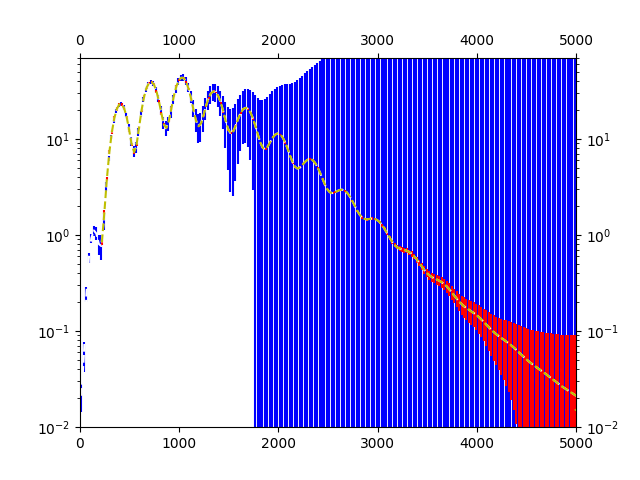

(0, 5000)

In [9]:
errorbar(dot(mp.windows['EE'],range(5000)[mp.windowrange['EE']]),cmbp,\
         yerr=sqrt(diag(pcov_ell_2_5000['EEEE'])),fmt='--',color='w',ecolor='b')

errorbar(dot(ms.windows['EE'],range(5000)[ms.windowrange['EE']]),cmbs,\
         yerr=sqrt(diag(scov['EEEE'])),fmt='--',color='y',ecolor='r')

yscale("log", nonposy='clip')
tick_params(which='both',top=True,right=True,labeltop=True,labelright=True)
ylim(0.01,70)
yticks([.01,.1,1,10])

xlim(0,5000)

##  Lets try looking at the constraints on Yp and Neff from SPT3G + Planck

#### Set the parameters, you can throw everything for the model in here, fish_params will be included in the covariance. The first number in fish_param is the fiducial model value, second is step size and the last is the optional prior.

In [10]:
params={'H0':None,'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873e-09,0.0115e-9),
                           'ns':fish_param( 0.9681,0.0044),
                           #'mnu':fish_param(.06,0.01),
                           'nnu':fish_param(3.046,0.03),
                           'YHe':fish_param(.252,.014),
                           'lmax':6000,'lens_potential_accuracy':2.0}

####  Calculate the fisher matrices for planck and spt

In [11]:
full_pcov = make_full_cov(['TT','EE','TE'],pcov_ell_2_5000)
Fp=Fisher_Matrix(params,full_pcov,
                 planck_model(specrange = [('TT',(2,3000)),('EE',(2,5000)),('TE',(2,5000))]))

0 YHe 0.0254674454567
1 clamp 2.24647292644e-11
2 cosmomc_theta 1.93070424127e-05
3 nnu 0.492172000603
4 ns 0.0124493086517
5 ombh2 0.000303316771636
6 ommh2 0.00717612692331
7 tau 0.0127187691468


In [12]:
full_scov = make_full_cov(['TT','EE','TE'],scov)
Fs=Fisher_Matrix(params,full_scov,spt3G_model(specrange = [('TT',(200,3000)),
                                ('EE',(200,5000)),
                                ('TE',(200,5000))]))

0 YHe 0.0211787805259
1 clamp 2.11594925573e-11
2 cosmomc_theta 1.34096869177e-05
3 nnu 0.411530031352
4 ns 0.0122592703552
5 ombh2 0.000128513415751
6 ommh2 0.0062640166673
7 tau 0.0154754859618


#### Add matrices to get the joint constraint

In [13]:
Fps = Fp[0]+Fs[0]

### Now some functions for making sloppy plots

#### make the x and y range in terms of sigma

In [14]:
def contour_range(mu,std,nsig=4,points=100):
    return linspace(mu-nsig*std,mu+nsig*std,points)

#### function for making the contours

In [15]:
def sig_contours(mu,sigma,colors='k'):
    x=contour_range(mu[0],sqrt(sigma[0,0]),nsig=5)
    y=contour_range(mu[1],sqrt(sigma[1,1]),nsig=5)
    X,Y=meshgrid(x,y)
    Z = bivariate_normal(X, Y, sigmax=sqrt(sigma[0,0]), sigmay=sqrt(sigma[1,1]),
                      mux=mu[0], muy=mu[1],sigmaxy=sigma[0,1])
    z1 = bivariate_normal(mu[0]+sqrt(sigma[0,0])*1, mu[1], sigmax=sqrt(sigma[0,0]), sigmay=sqrt(sigma[1,1]),
                      mux=mu[0], muy=mu[1],sigmaxy=sigma[0,1])
    z2 = bivariate_normal(mu[0]+sqrt(sigma[0,0])*2, mu[1], sigmax=sqrt(sigma[0,0]), sigmay=sqrt(sigma[1,1]),
                      mux=mu[0], muy=mu[1],sigmaxy=sigma[0,1])
        
    return contour(Y, X, Z,[z2,z1],colors=colors)
        


### And throw everything together to make the plot

<IPython.core.display.Javascript object>


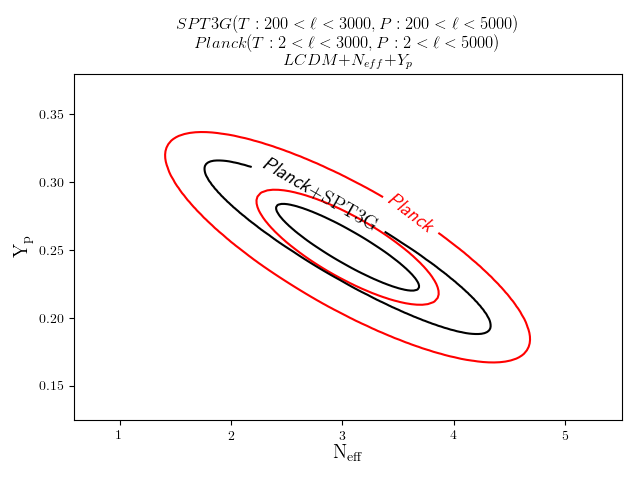

In [16]:
mu = [.252,3.046]
sigmap = array([[inv(Fp[0])[0,0],inv(Fp[0])[0,3]],[inv(Fp[0])[3,0],inv(Fp[0])[3,3]]])
sigmaps = array([[inv(Fps)[0,0],inv(Fps)[0,3]],[inv(Fps)[3,0],inv(Fps)[3,3]]])
xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$\rm{Y}_{\rm{p}}$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<3000,P:2<\ell<5000)$'+ \
'\n $LCDM$+$N_{eff}$+$Y_p$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs1=sig_contours(mu,sigmaps,colors = 'k')
fmt1=dict(zip(cs1.levels,[r'$\textit{Planck}$+$\rm{SPT3G}$',r'$\textit{Planck}$+$\rm{SPT3G}$']))
fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))

clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2, fontsize=14)
clabel(cs1,cs1.levels[::2], inline=True, fmt=fmt1, fontsize=14)
xlabel(xlab, fontsize=14)
ylabel(ylab, fontsize=14)
title(titl)
tight_layout()
savefig('Figures/Yp_Neff_constraints_planck_and_planckSPT3G.pdf')

## Now lets look at H0 and Omegabh^2 vs Neff with and without Planck ell>800

#### First make the fisher matrices need for LCDM+Neff

In [17]:
params={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873e-09,0.0115e-9),
                           'ns':fish_param( 0.9681,0.0044),
                           'nnu':fish_param(3.046,0.03),
                           
                           'lmax':6000,'lens_potential_accuracy':2.0}

In [18]:
Fp_5000_h0_neff=Fisher_Matrix(params,make_full_cov(['TT','EE','TE'],pcov_ell_2_5000),planck_model(specrange = [('TT',(2,3000)),
                                ('EE',(2,5000)),
                                ('TE',(2,5000))]))

0 H0 2.07923931631
1 clamp 1.72667956115e-11
2 nnu 0.241924656791
3 ns 0.0122123683559
4 ombh2 0.000304255383096
5 ommh2 0.00361648318125
6 tau 0.0127340045321


In [19]:
pcov_ell_2_800=pload(open( "Covariances/planck_cov_ell_2_800.p", "rb" ))

In [20]:
Fp_800_h0_neff=Fisher_Matrix(params,make_full_cov(['TT','EE','TE'],pcov_ell_2_800),planck_model(specrange = [('TT',(2,800)),
                                ('EE',(2,800)),
                                ('TE',(2,800))]))

0 H0 3.17510710234
1 clamp 3.67954200511e-11
2 nnu 0.506878282004
3 ns 0.0161731039397
4 ombh2 0.000404848702821
5 ommh2 0.00845214734374
6 tau 0.0129573183028


In [21]:
Fs_h0_neff=Fisher_Matrix(params,make_full_cov(['TT','EE','TE'],scov),spt3G_model(specrange = [('TT',(200,3000)),
                                ('EE',(200,5000)),
                                ('TE',(200,5000))]))

0 H0 1.19128054744
1 clamp 1.43065571622e-11
2 nnu 0.141632068386
3 ns 0.0123321529049
4 ombh2 0.000129233804722
5 ommh2 0.00293208299103
6 tau 0.0153489824977


In [22]:
Fps_5000_h0_neff = Fp_5000_h0_neff[0]+Fs_h0_neff[0]
Fps_800_5000_h0_neff = Fp_800_h0_neff[0]+Fs_h0_neff[0]

#### And now the matrices for just LCDM

In [23]:
params={'H0':fish_param(67.90,0.55),#'cosmomc_theta': fish_param(1.04106e-2,0.00041),
                           'ombh2':fish_param(0.02227,0.0002),
                           'ommh2':fish_param(0.1413,0.0011),
                           'tau':fish_param(0.067,0.013, 0.02),
                           'clamp':fish_param(1.873e-09,0.0115e-9),
                           'ns':fish_param( 0.9681,0.0044),
                           #'nnu':fish_param(3.046,0.03),
                           
                           'lmax':6000,'lens_potential_accuracy':2.0}

In [24]:
Fp_5000_h0=Fisher_Matrix(params,make_full_cov(['TT','EE','TE'],pcov_ell_2_5000),planck_model(specrange = [('TT',(2,3000)),
                                ('EE',(2,5000)),
                                ('TE',(2,5000))]))

0 H0 0.863200115951
1 clamp 9.32619121993e-12
2 ns 0.00514540997829
3 ombh2 0.000191139887918
4 ommh2 0.00181223929784
5 tau 0.0122280273695


In [25]:
Fp_800_h0=Fisher_Matrix(params,make_full_cov(['TT','EE','TE'],pcov_ell_2_800),planck_model(specrange = [('TT',(2,800)),
                                ('EE',(2,800)),
                                ('TE',(2,800))]))

0 H0 1.40884014231
1 clamp 1.16694885795e-11
2 ns 0.0103252506082
3 ombh2 0.000341007843368
4 ommh2 0.00245984635819
5 tau 0.0128676038744


In [26]:
Fs_h0=Fisher_Matrix(params,make_full_cov(['TT','EE','TE'],scov),spt3G_model(specrange = [('TT',(200,3000)),
                                ('EE',(200,5000)),
                                ('TE',(200,5000))]))


0 H0 0.737308963691
1 clamp 1.33083841432e-11
2 ns 0.00676724569713
3 ombh2 9.57396700148e-05
4 ommh2 0.00193208282472
5 tau 0.0149781941618


In [27]:
Fps_5000_h0 = Fp_5000_h0[0]+Fs_h0[0]
Fps_800_5000_h0 = Fp_800_h0[0]+Fs_h0[0]

## Constraints on H0 and Neff with Full Planck Data

<IPython.core.display.Javascript object>


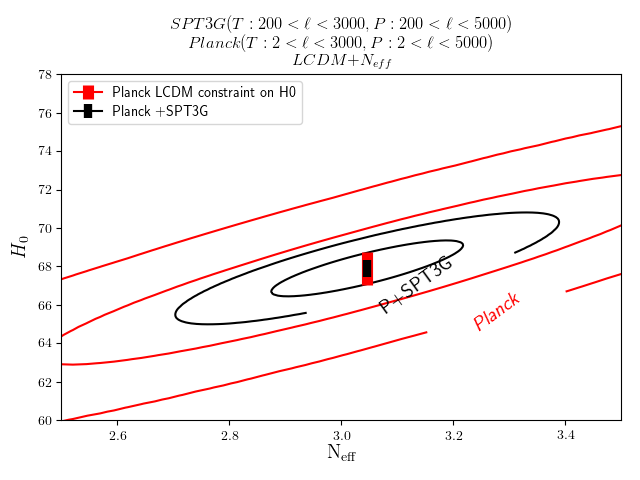

In [52]:
mu = [67.9,3.046]
sigmap = array([[inv(Fp_5000_h0_neff[0])[0,0],inv(Fp_5000_h0_neff[0])[0,2]],[inv(Fp_5000_h0_neff[0])[2,0],
                                                                    inv(Fp_5000_h0_neff[0])[2,2]]])
sigmaps = array([[inv(Fps_5000_h0_neff)[0,0],inv(Fps_5000_h0_neff)[0,2]],[inv(Fps_5000_h0_neff)[2,0],
                                                                inv(Fps_5000_h0_neff)[2,2]]])


xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$H_0$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<3000,P:2<\ell<5000)$'+ \
'\n $LCDM$+$N_{eff}$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs1=sig_contours(mu,sigmaps,colors = 'k')

fmt1=dict(zip(cs1.levels,['P+SPT3G','P+SPT3G']))
fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))


clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2,fontsize=14)
clabel(cs1,cs1.levels[::2], inline=True, fmt=fmt1,fontsize=14)
errorbar(mu[1],mu[0],yerr = sqrt(inv(Fp_5000_h0[0])[0,0]),color='r',elinewidth=8,label='Planck LCDM constraint on H0')
errorbar(mu[1],mu[0],yerr = sqrt(inv(Fps_5000_h0)[0,0]),color='k',elinewidth=6,label='Planck +SPT3G')

xlabel(xlab,fontsize=14)
ylabel(ylab,fontsize=14)
title(titl)
legend(loc='upper left')
ylim(60,78)
xlim(2.5,3.5)

tight_layout()
savefig('Figures/H0_Neff_constraints_planck_and_planckSPT3G.pdf')

## Constraints on H0 and Neff with Planck (ell< 800)

<IPython.core.display.Javascript object>


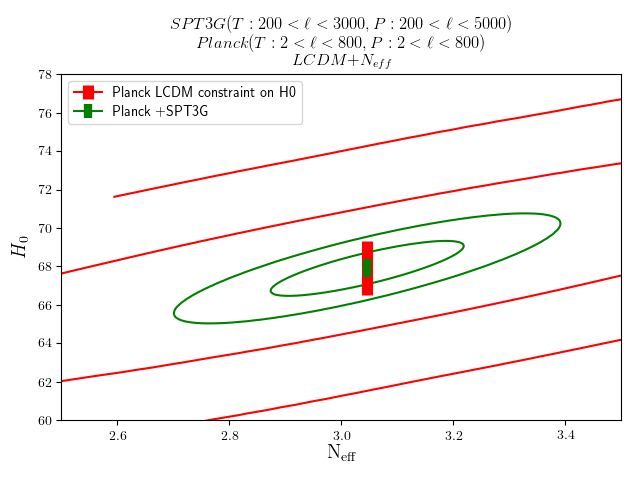

In [64]:
mu = [67.9,3.046]
sigmap = array([[inv(Fp_800_h0_neff[0])[0,0],inv(Fp_800_h0_neff[0])[0,2]],[inv(Fp_800_h0_neff[0])[2,0],
                                                                    inv(Fp_800_h0_neff[0])[2,2]]])

sigmaps_800 = array([[inv(Fps_800_5000_h0_neff)[0,0],inv(Fps_800_5000_h0_neff)[0,2]],
                     [inv(Fps_800_5000_h0_neff)[2,0],inv(Fps_800_5000_h0_neff)[2,2]]])

xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$H_0$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<800,P:2<\ell<800)$'+ \
'\n $LCDM$+$N_{eff}$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs3=sig_contours(mu,sigmaps_800,colors = 'g')

fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))
fmt3=dict(zip(cs3.levels,['P+SPT3G','P+SPT3G']))


clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2,fontsize=14)
clabel(cs3,cs3.levels[::2], inline=True, fmt=fmt3, fontsize=14)
errorbar(mu[1],mu[0],yerr = sqrt(inv(Fp_800_h0[0])[0,0]),color='r',elinewidth=8,label='Planck LCDM constraint on H0')
errorbar(mu[1],mu[0],yerr = sqrt(inv(Fps_800_5000_h0)[0,0]),color='g',elinewidth=6,label='Planck +SPT3G')

xlabel(xlab,fontsize=14)
ylabel(ylab,fontsize=14)
title(titl)
legend(loc='upper left')
ylim(60,78)
xlim(2.5,3.5)
tight_layout()

savefig('Figures/H0_Neff_constraints_planck_and_planck_800SPT3G.pdf')

## Constraints on Omegabh^2 and Neff with Full Planck Data

<IPython.core.display.Javascript object>


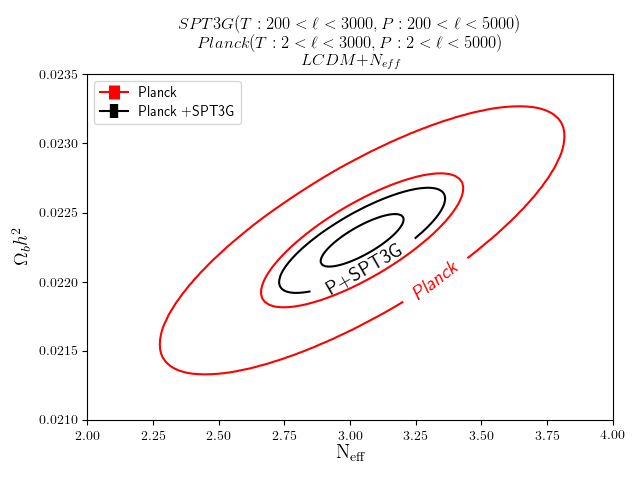

In [68]:
mu = [0.0223,3.046]
sigmap = array([[inv(Fp_5000_h0_neff[0])[4,4],inv(Fp_5000_h0_neff[0])[4,2]],[inv(Fp_5000_h0_neff[0])[2,4],
                                                                    inv(Fp_5000_h0_neff[0])[2,2]]])
sigmaps = array([[inv(Fps_5000_h0_neff)[4,4],inv(Fps_5000_h0_neff)[4,2]],[inv(Fps_5000_h0_neff)[2,4],
                                                                inv(Fps_5000_h0_neff)[2,2]]])


xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$\Omega_bh^2$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<3000,P:2<\ell<5000)$'+ \
'\n $LCDM$+$N_{eff}$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs1=sig_contours(mu,sigmaps,colors = 'k')

fmt1=dict(zip(cs1.levels,['P+SPT3G','P+SPT3G']))
fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))


clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2,fontsize=14)
clabel(cs1,cs1.levels[::2], inline=True, fmt=fmt1,fontsize=14)
errorbar(0,0,yerr = 0,color='r',elinewidth=8,label='Planck ')
errorbar(0,0,yerr = 0,color='k',elinewidth=6,label='Planck +SPT3G')
legend(loc='upper left')

xlabel(xlab,fontsize=14)
ylabel(ylab,fontsize=14)
title(titl)
xlim(2,4)
ylim(.021,.0235)
tight_layout()
savefig('Figures/omegabh2_Neff_constraints_planck_and_planckSPT3G.pdf')

## Constraints on Omegabh^2 and Neff with Planck (ell < 800)

<IPython.core.display.Javascript object>


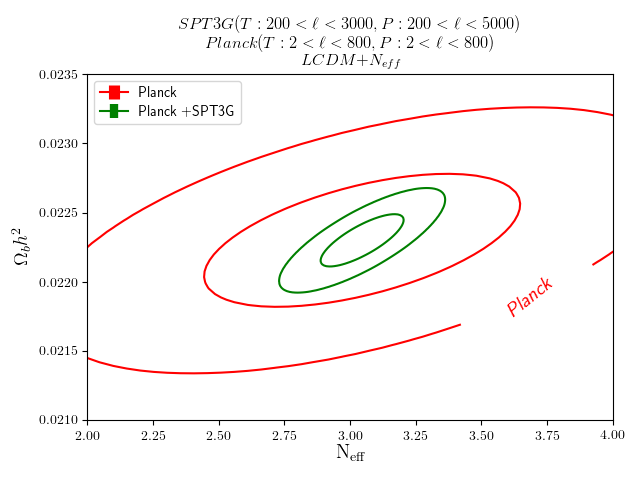

In [69]:
mu = [0.0223,3.046]
sigmap = array([[inv(Fp_800_h0_neff[0])[4,4],inv(Fp_800_h0_neff[0])[4,2]],[inv(Fp_800_h0_neff[0])[2,4],
                                                                    inv(Fp_800_h0_neff[0])[2,2]]])

sigmaps_800 = array([[inv(Fps_800_5000_h0_neff)[4,4],inv(Fps_800_5000_h0_neff)[4,2]],
                     [inv(Fps_800_5000_h0_neff)[2,4],inv(Fps_800_5000_h0_neff)[2,2]]])

xlab = r'$\rm{N}_{\rm{eff}}$'
ylab = r'$\Omega_bh^2$'
titl='$SPT3G(T:200<\ell<3000,P:200<\ell<5000)$'+ \
'\n $Planck(T:2<\ell<800,P:2<\ell<800)$'+ \
'\n $LCDM$+$N_{eff}$'

matplotlib.rc('text', usetex = True)
figure()
cs2=sig_contours(mu,sigmap,colors = 'r')
cs3=sig_contours(mu,sigmaps_800,colors = 'g')

fmt2=dict(zip(cs2.levels,[r'$\textit{Planck}$',r'$\textit{Planck}$']))
fmt3=dict(zip(cs3.levels,['P+SPT3G','P+SPT3G']))


clabel(cs2,cs2.levels[::2], inline=True, fmt=fmt2,fontsize=14)
clabel(cs3,cs3.levels[::2], inline=True, fmt=fmt3, fontsize=14)
errorbar(0,0,yerr = 0,color='r',elinewidth=8,label='Planck ')
errorbar(0,0,yerr = 0,color='g',elinewidth=6,label='Planck +SPT3G')
legend(loc='upper left')

xlabel(xlab,fontsize=14)
ylabel(ylab,fontsize=14)
title(titl)
xlim(2,4)
ylim(.021,.0235)
tight_layout()
savefig('Figures/omegabh2_Neff_constraints_planck_and_planck_800SPT3G.pdf')

## One more test, make the left panel of Figure 23 from the S4 science book

#### We will do this for a 1' beam the y axis is the constraint on Neff and the x axis is the sky fraction

#### My result is a bit off. For fsky = .4 the constraint on Neff is .03 in the science book but I get .04. If I reduced the covariance by a factor of two I get a more similar result

In [70]:
params={'H0':None,'cosmomc_theta': fish_param(1.0438e-2,1.3e-5),
                           'ombh2':fish_param(0.0223,0.001),
                           'ommh2':fish_param(0.13,0.007),
                           'tau':fish_param(0.083,0.02, 0.02),
                           'clamp':fish_param(1.93e-09,4.5e-11),
                           'ns':fish_param(0.9623,0.032),
                           'nnu':fish_param(3.046,0.03),
                           
                           'lmax':6000,'lens_potential_accuracy':2.0}

#### This next cell can take some time depending on your machine, you might want to get some coffee.
We are calculating 8 fisher matrices for 7 parameters and camb gets called twice for each parameter, so 112 calls to camb

In [71]:
results=[]
for fsky in arange(.1,.9,.1):
    s4cov=create_basic_cov(fsky,.0003,(sqrt(fsky/.4),'ukarc'),
                     specrange = (2,5000),
                     bin_size = 24,
                     spectra=('TT','EE','TE'),
                     )
    Fs4=Fisher_Matrix(params,make_full_cov(['TT','EE','TE'],s4cov),
                 planck_model(bin_size=24,specrange = [('TT',(2,3000)),('EE',(2,5000)),('TE',(2,5000))]))[0]
    results.append((fsky,sqrt(inv(Fs4)[2,2])))

0 clamp 8.26252298269e-12
1 cosmomc_theta 1.72699055139e-06
2 nnu 0.0672826272698
3 ns 0.00616352185354
4 ombh2 6.28579809441e-05
5 ommh2 0.00134373219658
6 tau 0.00845187907781
0 clamp 6.28587419528e-12
1 cosmomc_theta 1.26857957302e-06
2 nnu 0.0523005148722
3 ns 0.00453874519848
4 ombh2 4.89014021615e-05
5 ommh2 0.0010718967316
6 tau 0.00627964039372
0 clamp 5.31465230423e-12
1 cosmomc_theta 1.05905065878e-06
2 nnu 0.0447700480843
3 ns 0.00377905211806
4 ombh2 4.23338157379e-05
5 ommh2 0.000922708011516
6 tau 0.00522546567238
0 clamp 4.70472204066e-12
1 cosmomc_theta 9.31818036041e-07
2 nnu 0.0399941821178
3 ns 0.00331492685923
4 ombh2 3.82540388323e-05
5 ommh2 0.000824343980944
6 tau 0.00457336383538
0 clamp 4.27547977128e-12
1 cosmomc_theta 8.4397336079e-07
2 nnu 0.036614304841
3 ns 0.00299367182532
4 ombh2 3.53841550477e-05
5 ommh2 0.000753280590418
6 tau 0.00411913388766
0 clamp 3.95217142155e-12
1 cosmomc_theta 7.78618144594e-07
2 nnu 0.0340578526765
3 ns 0.00275425710068
4 ombh

In [72]:
fskys,Neffs=zip(*results)

<IPython.core.display.Javascript object>


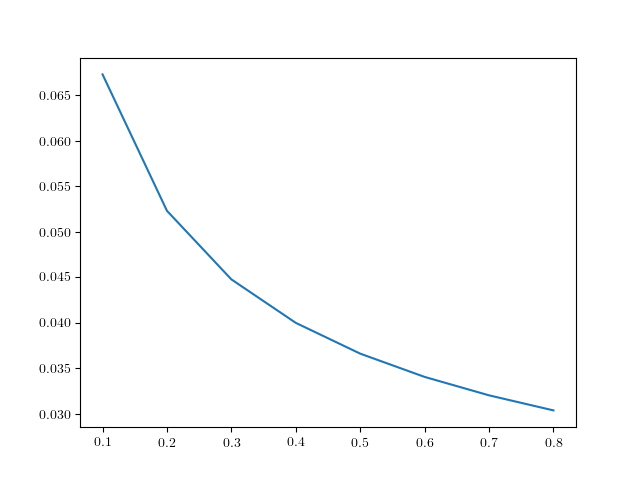

In [75]:
plot(fskys,array(Neffs))